# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Import modules.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import secrets
import ae353_drone

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create and print a seed for the random number generator so it is possible to reproduce the results. Here are a few best practices:

* By default, keep this code unchanged.
* When producing final results for your report, (1) run this cell once to create a seed, (2) copy/paste this seed into the line of code that creates a simulator, and (3) replace the code cell that creates a seed with a markdown cell saying that you took this approach to choose a seed for testing.

In [39]:
seed = secrets.randbits(32)
print(seed)

2213490577


Create simulator with seed.

If your simulator runs much slower than real-time, then you can try adding the optional argument `display_pybullet=True` (instead of using meshcat views).

In [40]:
simulator = ae353_drone.Simulator(seed=seed)

Add a camera view. This view will be displayed in its own browser window.

In [41]:
simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'start',          # type of view (start, top, right, left, or back)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/


## Example of how to add a drone and run a simulation

Clear all drones (there aren't any yet, if you are running this notebook from the start, but we call this function just in case).

In [42]:
simulator.clear_drones()

Define a controller for the drone.

In [43]:
import numpy as np

class Controller:
    def __init__(self):

        # System matrices and LQR/Observer gains
        self.A = np.array([[  0,   0,   0,   0,   0,   0,   1,   0,   0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    1  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0  ],
            [ 0,    0,    0,    0,    9.81,  0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,   -9.81,  0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ],
            [ 0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0  ]])
        self.B = np.array([[  0,          0,          0,          0      ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          0       ],
            [  0,          0,          0,          2       ],
            [434.7826087,   0,          0,          0       ],
            [  0,        434.7826087,   0,          0       ],
            [  0,          0,        250,          0      ]])
        self.C = np.array([[ 1,     0,     0,    -0.175,  0,     0,     0,     0,     0,     0,
            0,     0  ],
            [ 0,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0   ],
            [ 0,     0,     1,     0,     0,     0.175,  0,     0,     0,     0,
            0,     0   ],
            [ 1,     0,     0,     0.175,  0,     0,     0,     0,     0,     0,
             0,     0  ],
            [ 0,     1,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0   ],
            [ 0,     0,     1,     0,     0,    -0.175,  0,     0,     0,     0,
              0,     0   ]])
        self.K = np.array([[0,         -0.1,         0,          0,         0,          0.58989632,
             0,         -0.11413338,  0,          0.11275426, 0,          0       ],
            [ 0.1,         0,         0,         0,          0.58989632,  0,
              0.11413338,  0,          0,         0,          0.11275426, 0        ],
            [0,         0,         0,          0.31622777, 0,          0,
             0,         0,         0,          0,         0,          0.11193669],
            [ 0,         0,          0.4472136,   0,          0,          0,
              0,         0,          0.68353024,  0,          0,         0        ]])
        self.L = np.array([[ 2.97537602, 0,          0,          2.97537602, 0,         0        ],
            [0.,          2.92711379, -0.21976816, 0,          2.92711379,  0.21976816],
            [ 0,          0,          1.09868411, 0,          0,          1.09868411],
            [-2.13087076,  0,         0,          2.13087076,  0,          0        ],
            [ 1.30543174, 0,          0,          1.30543174, 0,         0       ],
            [ 0,         -1.25581808,  0.30429738,  0,         -1.25581808, -0.30429738],
            [ 8.35286245, 0,          0,          8.35286245, 0,         0        ],
            [0,          8.1162932,  -1.19153357, 0,          8.1162932,   1.19153357],
            [0,          0.,          0.70710678,  0,          0,          0.70710678],
            [ 0,         -0.67683134,  0.20469329,  0,         -0.67683134, -0.20469329],
            [ 0.70710678, 0,          0,          0.70710678, 0,         0        ],
            [-0.70710678,  0,         0,          0.70710678,  0,          0       ]])

        # Equilibrium states and inputs
        self.me = np.zeros(12)                      
        self.ne = np.array([0., 0., 0., 4.905])  # Corrected equilibrium thrust (m*g = 0.5*9.81)
        self.markere = np.array([0., 0.175, 0., 0., -0.175, 0.])

        #Extras
        self.xhat = np.array([0.,0.,0.5,0.,0.,0.,0.,0.,0.,0.,0.,0.])
        self.emax = 2
        self.dt = 0.4
        self.t = 0

        self.variables_to_log = ['xhat', 'xdes', 'ring']

    def get_color(self):
        return [3., 1., 2.]  # Pink drone color

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.array([p_x,p_y,p_z,
                              yaw,0,0,
                              0,0,0,
                              0,0,0])
        self.t = 0

    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        phat = self.xhat[0:3]
        x_des = pos_ring - dir_ring

        if np.linalg.norm(pos_ring - phat) < 1.25:
            x_des = pos_ring + dir_ring
        else:
            x_des = pos_ring - dir_ring
        if phat[2] < 1 and not is_last_ring:
            x_des += np.array([0,0,2])

        x_des = phat + ((self.emax * (x_des - phat)) / np.linalg.norm(x_des - phat))

        return np.concatenate([x_des, np.zeros(9)])

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):

        xdes = self.get_xdes(self.t, self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)

        u = -self.K @ (self.xhat - xdes)
        y = pos_markers - self.markere

        self.xhat += ((self.A @ self.xhat) + (self.B @ u) - self.L@(self.C @ self.xhat - y))*0.04

        tau = u + self.ne
        self.t += self.dt

        tau_x = tau[0]
        tau_y = tau[1]
        tau_z = tau[2]
        f_z = tau[3]

        return tau_x, tau_y, tau_z, f_z

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'template'` is the name of the drone
* `'template.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [44]:
simulator.add_drone(Controller, 'template', 'template.png')

Reset the drone (i.e., place it at a random location in the start ring).

In [45]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone has either reached the finish ring or been disqualified.

In [46]:
simulator.run(
    max_time=5.,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=True,  # <-- if False, then nothing will be printed (good for data collection)
)

Simulated 126 time steps in 5.0455 seconds (24.9727 time steps per second)


## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `template` to the simulator
* Ran the simulation

Get result.

In [21]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')

Show result.

In [22]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone did not finish (yet).


Get data.

In [23]:
data = simulator.get_data('template')

Plot data.

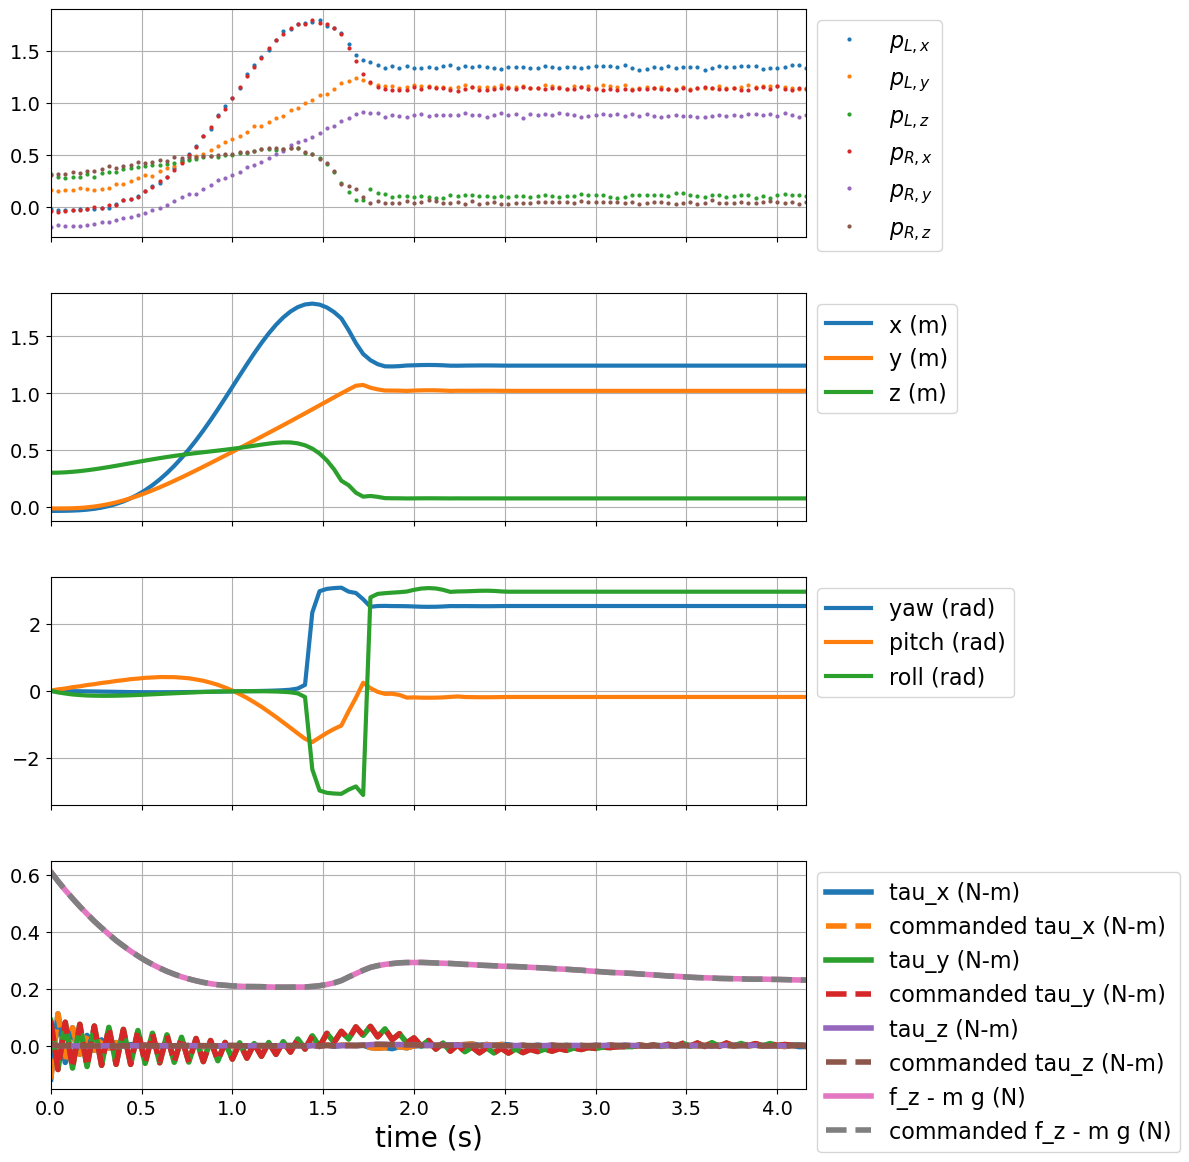

In [24]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Save the figure (without transparent background). Here are some best practices:

* Use the extension `.png` for rasterized, low-res images (e.g., to include in a notebook or on a website).
* Use the extension `.pdf` for vectorized, high-res images (e.g., to include in a report).

In [ ]:
#fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot histogram of controller run times.

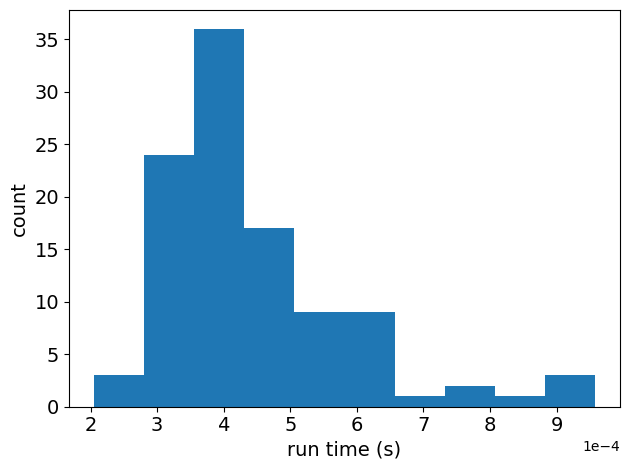

In [25]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

## Example of how to load drones from the "students" directory

Clear all drones.

In [26]:
simulator.clear_drones()

Load drones from `students` directory.

In [27]:
failures = simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [28]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [29]:
simulator.run(max_time=5.0)

KeyboardInterrupt: 

## Example of how to show results and keep running

Show results (so far).

In [30]:
simulator.show_results()

FINISHED

STILL RUNNING
 template            

FAILED


Continue running simulation from same point for `max_time` seconds or until all drones either finish or are disqualified.

In [ ]:
simulator.run(max_time=10.0)

Show results (so far).

In [ ]:
simulator.show_results()

## Example of how to clear and reload drones

Clear all drones.

In [31]:
simulator.clear_drones()

Load drones again from `students` directory.

In [32]:
failures = simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.place_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to add and remove views

Add another static view in a new browser window.

In [ ]:
simulator.add_view(
    'my_top_view',  # name of view (must be unique)
    'top',          # type of view (start, top, right, left, or back)
)

Add a view of a ring in a new browser window.

In [ ]:
simulator.add_ring_view(
    'my_ring_view', # name of view (must be unique)
    1,              # index of ring (between 1 and 14)
    yaw=180.,       # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    distance=2.5,   # how far away the camera is from the center of the ring
)

Add a view of a drone in a new browser window.

In [ ]:
simulator.add_drone_view(
    'my_drone_view',    # name of view (must be unique)
    'template',         # name of drone
    yaw=0.,             # yaw angle in degrees (0 looks forward, 180 looks backward, etc.)
    pitch=15.,          # pitch angle in degrees,
    distance=2.,        # how far away the camera is from the center of the drone
)

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Remove the top view. The browser window that contains this view will no longer be updated.

In [ ]:
simulator.remove_view(
    'my_top_view',      # name of view to remove
)

Reset drones (places drones at random positions within the start ring). Notice that the top view isn't updated, because it no longer exists.

In [ ]:
simulator.reset()

Add another static view — from the right this time instead of from the top. This new view should appear in the same browser window that formerly contained the top view.

In [ ]:
simulator.add_view(
    'my_right_view',    # name of view (must be unique)
    'right',            # type of view (start, top, right, left, or back)
)

Reset drones (places drones at random positions within the start ring). Notice that the (new) right view *is* updated,

In [ ]:
simulator.reset()

## Example of how to take a snapshot

Display a snapshot.

In [ ]:
# Set the width and height of the snapshot (must be multiples of 16)
simulator.set_snapshot_size(
    640, # <-- width
    480, # <-- height
)

# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot(
    'my_start_view',    # name of view from which to take a snapshot
)

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish, saving movies from two different views. You can add or remove elements to the list of `videos` to save more or fewer movies.

In [ ]:
simulator.run(
    max_time=1.0,
    videos=[
        {
            'view_name': 'my_start_view',       # name of view from which to record a video
            'file_name': 'my_start_video.mp4',  # name of file to which video will be saved
        },
        {
            'view_name': 'my_drone_view',       # name of view from which to record a video
            'file_name': 'my_drone_video.mp4',  # name of file to which video will be saved
        }
    ],
    print_debug=True,   # this option is recommended when saving videos to track progress
)

## Example of how to allow print statements, long run times, and inactivity

By default, your controller will fail if any of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `1e-2` seconds for `run` (on more than 10 occasions).
* It moves less than `0.1` meters in `10.0` seconds.

You can relax these rules for the purpose of development if you want, as follows.

In [ ]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
    error_on_inactive=False, # <-- allow inactivity
)

## Example of how to find the position, orientation, and radius of each ring

This information should only be used for analysis.

In [ ]:
for i, ring in enumerate(simulator.rings):
    p = ring['p']        # <--- position of ring
    v = ring['R'][:, 0]  # <--- unit vector normal to ring (pointing through it)
    r = ring['radius']   # <--- radius of ring
    s = f'ring {i:2d}' + \
        f' : p ({p[0]:6.2f}, {p[1]:6.2f}, {p[2]:6.2f})' + \
        f' : v ({v[0]:6.2f}, {v[1]:6.2f}, {v[2]:6.2f})' + \
        f' : r ({r:6.2f})'
    print(s)

## Example of how to specify initial conditions

Reset the simulator with given initial conditions. The argument `initial_conditions` must be a dictionary. This dictionary must have an key/value pair for each drone in the simulator. The key must be the name of the corresponding drone. The value must, itself, be a dictionary with a key/value pair for each initial state and each initial measurement.

In [ ]:
simulator.reset(
    initial_conditions={
        'template': {
            'p_x': 0.,
            'p_y': 0.,
            'p_z': 0.5,
            'yaw': 0.,
            'pitch': 0.,
            'roll': 0.,
            'v_x': 0.,
            'v_y': 0.,
            'v_z': 0.,
            'w_x': 0.,
            'w_y': 0.,
            'w_z': 0.,
            'p_x_meas': 0.,
            'p_y_meas': 0.,
            'p_z_meas': 0.5,
            'yaw_meas': 0.,
        },
    },
)

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to disable and enable views

Disable views so they aren't updated while running simulations. These simulations will then run as fast as possible (much faster than real time), so this option is a good choice when collecting lots of data.

In [ ]:
simulator.disable_views()

Reset drones (places drones at random positions within the start ring). Note that views are still updated — it is only when running simulations that views aren't updated.

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish (should take much less than `max_time` seconds to run).

In [ ]:
simulator.run(max_time=5.0)

Enable views again.

In [ ]:
simulator.enable_views()

Run simulation for `max_time` seconds or until all drones finish (should take about `max_time` seconds to run).

In [ ]:
simulator.run(max_time=5.0)